### Forecasting Household Energy Consumption

This notebook employs linear autoregressive methods to forecast one-step ahead daily energy consumption values. The dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/jaganadhg/house-hold-energy-data/code). It has been reduced to a single variable, 'USAGE,' to predict one-step ahead values of the time series spanning two full years. To capture potential data patterns, the first year serves as the training set, with the first and second halves of the second year as the validation and test sets, respectively. Various techniques have been implemented to determine optimal model hyperparameters and lags, including autocorrelation and partial correlation plots (ACF and PACF). Additionally, the pyramid-arima function 'autoarima' uses two information loss metrics (AIC and BIC) to calculate the best parameters for model forecasting. For attempts to implement non-linear methods, please refer to [notebook two](https://github.com/BorjaDaguerre/Predicting_promotions/blob/main/(2)%20HouseHold_energy_forecasting-DeepLearningMethods.ipynb). This notebook contains predictions for daily usage (733 observations). Forecasts using hourly data (70,368 observations) are currently in progress and will be uploaded next week.

### Usefulness

This project showcases the capabilities of both linear and non-linear forecasting methods in predicting one-step ahead values. The approaches chosen here can be applied to a wide range of forecasting scenarios, making them valuable tools for various industries and domains. Here are some additional use cases for forecasting models in different companies:

* Retail: Predicting demand for products to optimize inventory management and prevent overstocking or understocking.
* Finance: Forecasting stock prices, currency exchange rates, and interest rates to make informed investment decisions.
* Supply Chain: Forecasting shipping and delivery times to improve logistics and meet customer expectations.
* Manufacturing: Forecasting production schedules and maintenance needs to minimize downtime and increase efficiency.
* E-commerce: Predicting customer churn and recommending products to enhance the shopping experience.
* Energy: Forecasting energy consumption to optimize production and distribution in the utility sector.
* Supply Chain: Forecasting shipping and delivery times to improve logistics and meet customer expectations.

The ability to uncover hidden data patterns and use them for predictive purposes is a versatile tool that can benefit organizations across various sectors. It allows them to make informed decisions, allocate resources efficiently, and enhance their overall performance.
### Dataset Information

Included Features:

* DATE: The date when the data was recorded.
* START TIME: The time when the data was recorded, measured every 15 minutes.
* END TIME: The time when data recording ended, with a 15-minute frequency.
* USAGE: Energy usage for the specified time, measured in kWh.
* UNITS: The units in which energy usage is measured: kWh.
* COST: Energy usage cost during the recorded time.
* NOTES: A column with NaN values.

Enjoy exploring the project! Any feedback is welcome at borjadaguerre@gmail.com.

In [20]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import datetime as dt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
warnings.filterwarnings("ignore")

In [2]:
# load the dataset and drop unnecesary columns

df = pd.read_csv('D202.csv')
df = df.drop(columns = ['NOTES','TYPE', 'UNITS'] )

# Number of years the time series covers\

len(np.unique(df['DATE']))/365

2.0082191780821916

In [3]:
# Check de data types per column

df.dtypes

DATE           object
START TIME     object
END TIME       object
USAGE         float64
COST           object
dtype: object

In [4]:
# Create a column with the data and the time, to create daily and hourly datasets 

df['FULL_DATE'] = ''

for date in df['DATE'].items():
    df['FULL_DATE'].loc[date[0]] = date [1] + ' ' + df['START TIME'].loc[date[0]] 
    
df['FULL_DATE'] = pd.to_datetime(df['FULL_DATE'])
df.index = df['FULL_DATE']

In [6]:
# Create hourly and daily datasets for forecasting


df['HOUR'] = [dt.replace(minute=0, second=0) for dt in df['FULL_DATE']]
df['DATE'] = [date for date in df.index.date]

daily_usage = df.groupby(['DATE']).agg({'USAGE':'sum'})
hourly_usage = df.groupby(['HOUR']).agg({'USAGE':'sum'})

In [7]:
# Separate trainning, validation, and daily data test sets for hourly and daily data


train_daily = daily_usage[:int(len(daily_usage) * 0.5)]
train_hourly = hourly_usage[:int(len(hourly_usage) * 0.5)]
validation_daily = daily_usage[int(len(daily_usage)* 0.5):-int(len(daily_usage) * 0.25)]
validation_hourly = hourly_usage[int(len(hourly_usage)* 0.5):-int(len(hourly_usage) * 0.25)]
test_daily = daily_usage[-int(len(daily_usage) * 0.25):]
test_hourly = hourly_usage[-int(len(hourly_usage) * 0.25):]

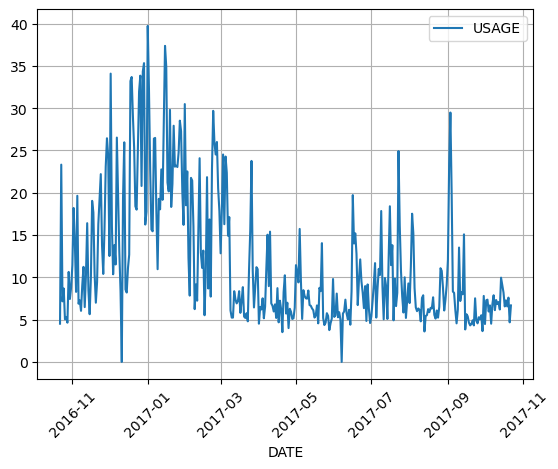

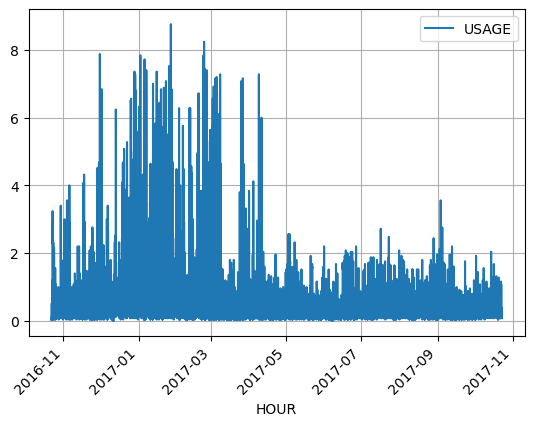

In [9]:
# Plot the train sets 

train_daily.plot()
plt.xticks(rotation= 45)
plt.grid()
train_hourly.plot()
plt.xticks(rotation= 45)
plt.grid()
plt.show()

In [10]:
# Check if data is stationary, otherwise further transformation would be needed

ad_test_daily = adfuller(train_daily)
ad_test_hourly = adfuller(train_hourly)

print(ad_test_daily[1], ad_test_hourly[1])

0.02167290392337092 1.1288019167673719e-10


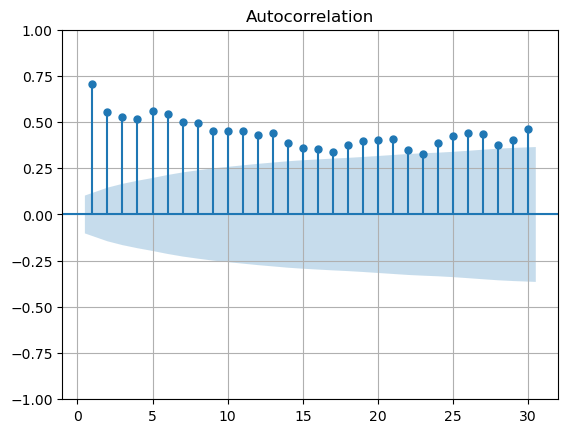

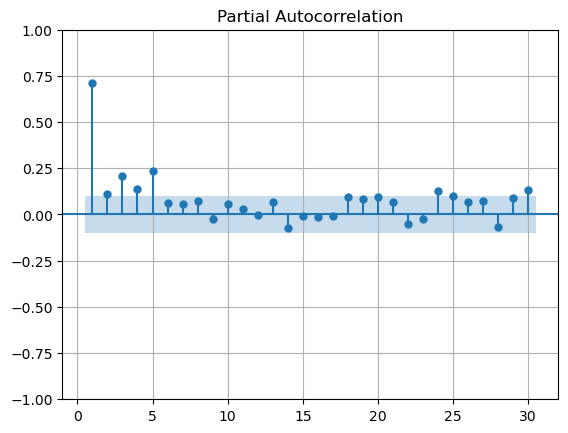

In [11]:
# Autorcorrelation and partial autorcorrelation of the daily and hourly data to calculate the namber of lags that should 
# be considered for the forecasting models 

plot_acf(train_daily,zero = False, lags =30);
plt.grid()
plot_pacf(train_daily, zero = False, lags = 30);
plt.grid()



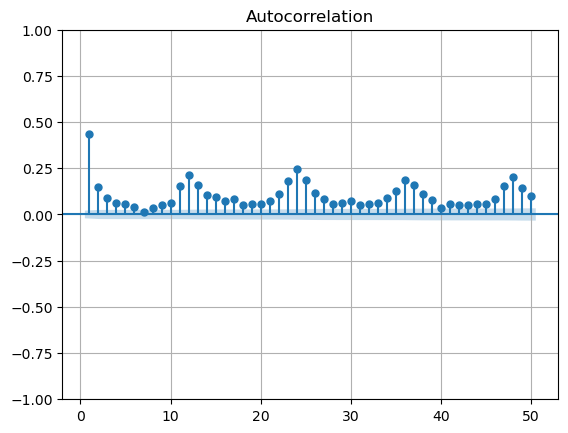

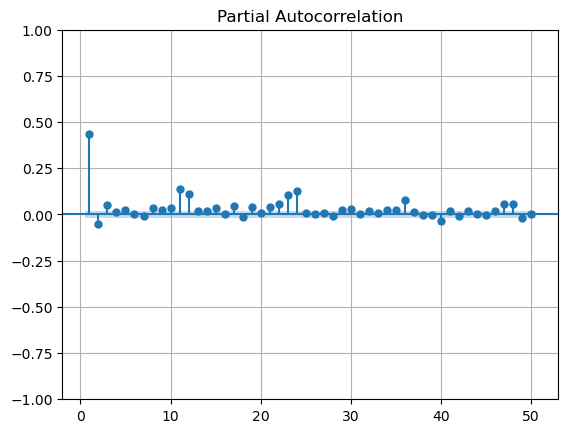

In [12]:
plot_acf(train_hourly,zero = False, lags =50);
plt.grid()
plot_pacf(train_hourly, zero = False, lags = 50);
plt.grid()

In [112]:
# Fit an ARIMA model using auto_arima

model = pm.auto_arima(train_daily, 
                      m=7,
                      d = 0,
                      max_p = 24,
                      max_q = 24)

# Print the summary of the best model
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1213.589
Date:                Mon, 21 Aug 2023   AIC                           2439.179
Time:                        14:21:04   BIC                           2462.595
Sample:                             0   HQIC                          2448.484
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9737      0.590      1.649      0.099      -0.183       2.131
ar.L1          0.1167      0.067      1.738      0.082      -0.015       0.248
ar.L2          0.8180      0.067     12.212      0.0

In [11]:
# Dinamically forecasting since ARIMA default model uses the coefficients generated at the end of the process to forecast. This
# method below trains the model dinamically, updating the coefficients step-by-step

def one_step_ahead_SARIMAX(modelo, train_data, test_data, order = None, seasonal_order = None):
    predictions = []
    conf_interval = []
    full_data = pd.concat([train_data, test_data], axis = 0 )
    for i in range(len(train_data), len(full_data)):
        if order is None:
            model = modelo(full_data[:i] )
            results = model.fit()
            prediction = results.predict(start=i)
            predictions.append(prediction[0])

        else:
            if seasonal_order is None:
                model = modelo(full_data[:i], order = order )
                results = model.fit()
                prediction = results.predict(start=i)
                predictions.append(prediction[0])

            else:
                model = modelo(full_data[:i], order = order, seasonal_order = seasonal_order )
                results = model.fit()
                prediction = results.predict(start=i)
                predictions.append(prediction[0])
                
    predictions_df = pd.DataFrame(data = predictions, index = test_data.index, columns = ['Predicted_values'])
    return predictions_df

In [15]:
# Add the validation set to the train set for the final test

train_full = pd.concat([train_daily, validation_daily], axis = 0)

In [18]:
SARIMAX_results = one_step_ahead_SARIMAX(SARIMAX, train_full, test_daily, order = (2,0, 2), seasonal_order = (1,0,1,7))

In [27]:
# MAE

round(mean_absolute_error(SARIMAX_results, test_daily),3)


2.219

In [25]:
# Plot predicted/actual and calculating MAE

plt.figure(figsize = (12,6), dpi = 1000)
plt.plot(SARIMAX_results, label = 'predicted')
plt.plot(test_daily, label = 'actual')
plt.title('One-step ahead SARIMAX forecast')
plt.legend()
plt.grid()